# House MD Cast Classification

### Imports

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision.models as models
from torchvision import transforms, datasets
import pytorch_lightning as L
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import matplotlib.pyplot as plt


### Hyperparams

In [3]:
WIDTH = HEIGHT = 256
CHANNELS = 3
EPOCHS = 10
LR = 0.001
DECAY = 0.0001
CLASSES = len(os.listdir("./train/"))


### Models

#### Model1

In [4]:
class HMD1(L.LightningModule):
    def __init__(self):
        super().__init__()
        # out_dims = (input_dims + 2p - k) / 1 + 1
        # #params = (input_channels * output_channels * kernel_size^2) + output_channels
        self.cnn = nn.Sequential(
            # = (256 + "2" - 3) / 1 + 1 = 256
            # = (3 * 32 * 9) + 32 = 896
            nn.Conv2d(CHANNELS, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # = (256 + 0 - 2) / 2 + 1 = 128
            nn.MaxPool2d(kernel_size=2, stride=2),
            # = (128 + "2" - 3) / 1 + 1 = 128
            # = (32 * 64 * 9) + 64 = 18,496
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # = (128 + 0 - 2) / 2 + 1 = 64
            nn.MaxPool2d(kernel_size=2, stride=2),
            # = (64 + "2" - 3) / 1 + 1 = 64
            # = (64 * 128 * 9) + 128 = 73,856
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # = (128 + 0 - 2) / 2 + 1 = 64
            nn.MaxPool2d(kernel_size=2, stride=2),
            # = 64 * 64 * 128
            nn.Flatten(),
        )
        self.mlp = nn.Sequential(
            nn.Linear(16 * 64 * 128, 64),
            nn.Linear(64, CLASSES),
            nn.Softmax(dim=1),
        )
        self.ce = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.cnn(x)
        y_h = self.mlp(x)
        return y_h

    def training_step(self, batch):
        x, y_t = batch[0], batch[1]
        y_h = self.forward(x)
        loss = self.ce(y_h, y_t)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y_t = batch[0], batch[1]
        y_h = self.forward(x)
        loss = self.ce(y_h, y_t)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)


#### Model2

In [20]:
class HMD2(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Freeze all layers except the last fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, CLASSES)
        self.ce = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, x):
        x, y_t = x
        y_h = self.forward(x)
        loss = self.ce(y_h, y_t)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_t = batch
        y_h = self.forward(x)
        loss = self.ce(y_h, y_t)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        x, y_t = batch
        y_h = self.forward(x)
        loss = self.ce(y_h, y_t)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)


### Training

In [34]:
model = HMD2()
model.train()
model_name = model.__class__.__name__
model_path = os.path.join("./lightning_logs/", model_name)


logger = loggers.TensorBoardLogger(name=model_name, save_dir="./lightning_logs")
train_dataset = datasets.ImageFolder(
    root="./train",
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
val_dataset = datasets.ImageFolder(
    root="./validation/",
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=model_path,
    filename="{epoch:02d}",
    save_top_k=3,  # save all checkpoints
    every_n_epochs=2,  # save a checkpoint every 3 epochs
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,  # stop training if validation loss does not improve for 3 epochs
    mode="min",  # minimize the validation loss
)

trainer = L.Trainer(
    max_epochs=EPOCHS + 5,
    log_every_n_steps=10,
    accelerator="mps",
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
)
summary(model)
trainer.fit(
    model,
    train_dataloaders=DataLoader(train_dataset, num_workers=7, shuffle=True, batch_size=5),
    val_dataloaders=DataLoader(val_dataset, num_workers=7, shuffle=False, batch_size=5),
    ckpt_path="./lightning_logs/HMD2/epoch=09.ckpt",
)
torch.save(model, os.path.join(model_path, (model_name + ".pt")))


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/pt/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/youssefahab/Development/DeepLearning/house-md-classification/lightning_logs/HMD2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at ./lightning_logs/HMD2/epoch=09.ckpt

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | ce    | CrossEntropyLoss | 0     
-------------------------------------------
3.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)
Restored all states from the checkpoint at ./lightning_logs/HMD2/epoch=09.ckpt


Epoch 14: 100%|██████████| 74/74 [01:11<00:00,  1.03it/s, v_num=2]         

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 74/74 [01:11<00:00,  1.03it/s, v_num=2]


### Testing

In [35]:
def get_key(val):
    for k, v in train_dataset.class_to_idx.items():
        if v == val:
            return k


train_dataset.class_to_idx


{'cameron': 0,
 'chase': 1,
 'cuddy': 2,
 'foreman': 3,
 'house': 4,
 'none': 5,
 'wilson': 6}

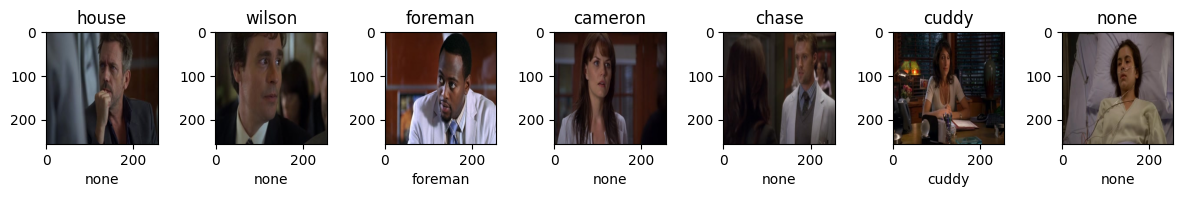

In [60]:
images = [
    "./validation/house/1.jpg",
    "./validation/wilson/1.jpg",
    "./validation/foreman/1.jpg",
    "./validation/cameron/1.jpg",
    "./validation/chase/1.jpg",
    "./validation/cuddy/5.jpg",
    "./validation/none/1.jpg",
]
model.freeze()
model.eval()
fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
fig.tight_layout()
for i, image in enumerate(images):
    with Image.open(image) as img:
        axs[i].imshow(img)
        axs[i].set_title(image.split("/")[2])  # y_t
        prediction = model(transforms.ToTensor()(img).unsqueeze(0)).detach()
        prediction = get_key(prediction.argmax(1))
        axs[i].set_xlabel(prediction)  # y_h
plt.show()


In [42]:
test_dataset = datasets.ImageFolder(root="./test", transform=transforms.ToTensor())
trainer.test(model, DataLoader(test_dataset, num_workers=7))


Testing DataLoader 0: 100%|██████████| 135/135 [00:01<00:00, 126.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.6682260036468506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.6682260036468506}]